## Adversarial Autoencoders on fMRI Images for Automatic Data Generation
In this notebook and the corresponding repository, we will focus on the use of adversarial autoencoders to attack problems relating to generating a usable embedding for the space of fMRI images for the purpose of understanding psychiatric diseases.

This notebook written for and executed with Python 3.5, Keras 2.1.2 and Tensorflow r1.4.
### Data Download
We will be using the minimally processed data from ABIDE 1 (more information can be found [here](http://preprocessed-connectomes-project.org/abide/)) for the purposes of this initial assessment. We have used the code below to download the fMRI data. We will utilize only a small number of these so that we can get a sense of the difficulty of the task.

In [ ]:
import sys
if sys.version_info[0] == 3:
    from urllib.request import urlopen
else:
    from urllib import urlopen
try:
    from StringIO import StringIO
except ImportError:
    from io import BytesIO as StringIO
import gzip
import csv

with open('abide/abide_file_names.csv', 'r') as f:
    reader = csv.reader(f)
    file_names = list(reader)

for i in range(len(file_names)):
    try:
        url = 'https://s3.amazonaws.com/fcp-indi/data/Projects/ABIDE_Initiative/Outputs/cpac/func_minimal/' + file_names[i][0] + '_func_minimal.nii.gz'
        outFilePath = file_names[i][0] + '_func_minimal.nii'
        response = urlopen(url)
        compressedFile = StringIO(response.read())
        decompressedFile = gzip.GzipFile(fileobj=compressedFile)

        with open('abide/' + outFilePath, 'wb') as outfile:
            outfile.write(decompressedFile.read())
    except:
        outFilePath = file_names[i][0] + '_func_minimal.nii'
        print(outFilePath + ' cannot be obtained.')

### Data Processing (To Be Improved)
In order to save on memory, we will be using basic bilinear interpolation to convert the time scale on fMRI images so that all images have a temporal dimensionality of 64. This methodology is not necessarily correct as we (I) have not read how fMRI data is captured in practice, but we have opted for performing the interpolation instead of picking the first $|T|=64$ temporal snapshots for this initial analysis.

In [ ]:
import nibabel as nib
import numpy as np
import copy
import h5py
import os

def save_large_dataset(file_name, variable):
    h5f = h5py.File(file_name + '.h5', 'w')
    h5f.create_dataset('variable', data=variable)
    h5f.close()
    
def tensor_interpolate(X,dim,size):
    original_shape = X.shape
    #new_shape = copy.copy(original_shape)
    #new_shape[dim] = size
    old_size = original_shape[dim]
    Y = []
    for i in range(size):
        low_j = int(np.floor(float(i)/float(size-1)*float(old_size-1)))
        ratio = float(i)/float(size-1)*float(old_size-1) - low_j
        high_j = min(size - 1, low_j + 1)
        Y.append(ratio*np.take(X, low_j, dim)+(1-ratio)*np.take(X, high_j, dim))
    print(len(Y))
    Y = np.vstack(Y)
    
    return Y


indir = 'abide/'
Xs = []
for root, dirs, filenames in os.walk(indir):
    for f in filenames:
        if '.nii' == f[-4:]:
            img = nib.load(indir + f)
            data = img.dataobj # Get the data object
            data = data[:-1,:-1,:-1,:] # Clean the last dimension for a high GCD
            X = np.expand_dims(data, 0)
            print('Target Embedding Dimension: ', np.prod(data.shape[:-1])/12/12/12)
            X = np.transpose(X, (0,4,1,2,3))
            X = np.expand_dims(X, 5)
            X = X / np.max(X)
            X = X.astype('float32')
            print('Shape: ', X.shape)
            X = tensor_interpolate(X, 1, 32)
            X = np.expand_dims(X, 0)
            print('Interpolated Shape: ', X.shape)
            Xs.append(X)
            
Xa = np.vstack(Xs)
save_large_dataset('Xa', Xa)

### Training
We will use the [keras-adversarial library](https://github.com/bstriner/keras-adversarial) to help us with our training. We use [this example](https://github.com/bstriner/keras-adversarial/blob/master/examples/example_aae_cifar10.py) as a basis.

In [1]:
import os
import h5py
import numpy as np
import pandas as pd
import matplotlib as mpl
mpl.use('Agg')

from keras.layers import Input, Reshape, Flatten, Lambda, Dense, Conv3D, MaxPooling3D, UpSampling3D, TimeDistributed
from keras.models import Sequential, Model
from keras.optimizers import Adam
import keras.backend as K

from keras_adversarial.legacy import l1l2, Dense, fit, Convolution2D
from keras_adversarial import AdversarialModel, fix_names, n_choice
from keras_adversarial import AdversarialOptimizerSimultaneous, normal_latent_sampling
from keras.layers import LeakyReLU, Activation

def load_large_dataset(file_name):
    h5f = h5py.File(file_name + '.h5','r')
    variable = h5f['variable'][:]
    h5f.close()
    return variable

X = load_large_dataset('Xa')

def model_generator(latent_dim):
    latent_dim_2 = 3
    input_layer = Input((latent_dim,))
    x = Dense(X.shape[1] * latent_dim_2)(input_layer)
    x = Reshape((X.shape[1], latent_dim_2))(x)
    x = TimeDistributed(Dense(5*6*5))(x)
    x = TimeDistributed(Reshape((5, 6, 5, 1)))(x)
    x = TimeDistributed(Conv3D(32, 3, 3, 3, activation='relu', border_mode='same'))(x)
    x = TimeDistributed(UpSampling3D((3, 3, 3)))(x)
    x = TimeDistributed(Conv3D(32, 7, 7, 7, activation='relu', border_mode='same'))(x)
    x = TimeDistributed(UpSampling3D((2, 2, 2)))(x)
    x = TimeDistributed(Conv3D(32, 5, 5, 5, activation='relu', border_mode='same'))(x)
    x = TimeDistributed(UpSampling3D((2, 2, 2)))(x)
    x = TimeDistributed(Conv3D(16, 5, 5, 5, activation='relu', border_mode='same'))(x)
    generated = TimeDistributed(Conv3D(1, 5, 5, 5, activation='linear', border_mode='same'))(x)
    return Model(input_layer, generated, name='decoder')


def model_encoder(latent_dim, input_shape, reg=lambda: l1l2(1e-7, 0)):
    input_layer = Input(shape=X.shape[1:]) # Create the Input Layer
    x = TimeDistributed(Conv3D(8, 3, 3, 3, activation='relu', border_mode='same'), input_shape=X.shape[2:])(input_layer) 
    x = TimeDistributed(MaxPooling3D((2, 2, 2), padding='same'))(x)
    x = TimeDistributed(Conv3D(16, 3, 3, 3, activation='relu', border_mode='same'))(x) 
    x = TimeDistributed(MaxPooling3D((2, 2, 2), padding='same'))(x)
    x = TimeDistributed(Conv3D(32, 3, 3, 3, activation='relu', border_mode='same'))(x) 
    x = TimeDistributed(MaxPooling3D((3, 3, 3), padding='same'))(x)
    x = Flatten()(x)
    mu = Dense(latent_dim, name="encoder_mu", W_regularizer=reg())(x)
    log_sigma_sq = Dense(latent_dim, name="encoder_log_sigma_sq", W_regularizer=reg())(x)
    encoded = Lambda(lambda mulss : mulss[0] + K.random_normal(K.shape(mulss[0])) * K.exp(mulss[1] / 2),
               output_shape= (latent_dim,))([mu, log_sigma_sq])
    return Model(input_layer, encoded, name="encoder")


def model_discriminator(latent_dim, output_dim=1, units=256, reg=lambda: l1l2(1e-7, 1e-7)):
    input_layer = Input((latent_dim,))
    x = Dense(1024, activation = 'tanh')(input_layer)
    x = Dense(512, activation = 'tanh')(x)
    y = Dense(1, activation = 'sigmoid')(x)
    return Model(input_layer, y)


def example_aae(path, adversarial_optimizer, latent_dim = 32):
    input_shape = X.shape[1:]

    # Specify the generator (z -> x)
    generator = model_generator(latent_dim)
    # Specify the encoder (x -> z)
    encoder = model_encoder(latent_dim, input_shape)
    # Combining the encoder and the generator, specify the autoencoder (x -> x')
    autoencoder = Model(encoder.inputs, generator(encoder(encoder.inputs)))
    # Specify the discriminator (z -> y)
    discriminator = model_discriminator(latent_dim)

    # build the AAE
    x = encoder.inputs[0]
    z = encoder(x)
    xpred = generator(z)
    zreal = normal_latent_sampling((latent_dim,))(x)
    yreal = discriminator(zreal)
    yfake = discriminator(z)
    aae = Model(x, fix_names([xpred, yfake, yreal], ["xpred", "yfake", "yreal"]))

    # Generate summaries for the models
    generator.summary()
    encoder.summary()
    discriminator.summary()
    autoencoder.summary()

    # Build the adversarial model
    generative_params = generator.trainable_weights + encoder.trainable_weights
    model = AdversarialModel(base_model=aae,
                             player_params=[generative_params, discriminator.trainable_weights],
                             player_names=["generator", "discriminator"])
    model.adversarial_compile(adversarial_optimizer=adversarial_optimizer,
                              player_optimizers=[Adam(3e-4, decay=1e-4), Adam(1e-3, decay=1e-4)],
                              loss={"yfake": "binary_crossentropy", "yreal": "binary_crossentropy",
                                    "xpred": "mean_squared_error"},
                              player_compile_kwargs=[{"loss_weights": {"yfake": 1e-1, "yreal": 1e-1,
                                                                       "xpred": 1e2}}] * 2)

    # Split our data into training and testing
    xtrain = X[:135]
    xtest = X[135:150]
    
    # train network
    # generator, discriminator; pred, yfake, yreal
    n = xtrain.shape[0]
    y = [xtrain, np.ones((n,)), np.zeros((n,)), xtrain, np.zeros((n,)), np.ones((n,))]
    ntest = xtest.shape[0]
    ytest = [xtest, np.ones((ntest,)), np.zeros((ntest,)), xtest, np.zeros((ntest,)), np.ones((ntest,))]
    history = fit(model, x=xtrain, y=y, validation_data=(xtest, ytest),
                  callbacks=[],
                  nb_epoch=250, batch_size=2)

    # save history
    df = pd.DataFrame(history.history)
    df.to_csv(os.path.join(path, "history.csv"))

    # save model
    encoder.save(os.path.join(path, "encoder.h5"))
    generator.save(os.path.join(path, "generator.h5"))
    discriminator.save(os.path.join(path, "discriminator.h5"))

example_aae("aae-fmri", AdversarialOptimizerSimultaneous())

Using TensorFlow backend.
/home/mehmet/miniconda2/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:46: UserWarning: Update your `Conv3D` call to the Keras 2 API: `Conv3D(32, (3, 3, 3), padding="same", activation="relu")`
/home/mehmet/miniconda2/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:48: UserWarning: Update your `Conv3D` call to the Keras 2 API: `Conv3D(32, (7, 7, 7), padding="same", activation="relu")`
/home/mehmet/miniconda2/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:51: UserWarning: Update your `Conv3D` call to the Keras 2 API: `Conv3D(32, (5, 5, 5), padding="same", activation="relu")`
/home/mehmet/miniconda2/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:54: UserWarning: Update your `Conv3D` call to the Keras 2 API: `Conv3D(16, (5, 5, 5), padding="same", activation="relu")`
/home/mehmet/miniconda2/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:55: UserWarning: Update your `Conv3D

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 96)                3168      
_________________________________________________________________
reshape_1 (Reshape)          (None, 32, 3)             0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 32, 150)           600       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 32, 5, 6, 5, 1)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 32, 5, 6, 5, 32)   896       
_________________________________________________________________
time_distributed_4 (TimeDist (None, 32, 15, 18, 15, 32 0         
__________

Epoch 4/250
135/135 [==============================] - 189s 1s/step - loss: 3.1480 - generator_loss: 1.5731 - generator_xpred_loss: 0.0142 - generator_yfake_loss: 0.7477 - generator_yreal_loss: 0.7288 - discriminator_loss: 1.5749 - discriminator_xpred_loss: 0.0142 - discriminator_yfake_loss: 0.7414 - discriminator_yreal_loss: 0.7528 - val_loss: 3.0248 - val_generator_loss: 1.5124 - val_generator_xpred_loss: 0.0136 - val_generator_yfake_loss: 0.5307 - val_generator_yreal_loss: 0.9445 - val_discriminator_loss: 1.5124 - val_discriminator_xpred_loss: 0.0136 - val_discriminator_yfake_loss: 0.9440 - val_discriminator_yreal_loss: 0.5311
Epoch 5/250
135/135 [==============================] - 189s 1s/step - loss: 2.8952 - generator_loss: 1.4465 - generator_xpred_loss: 0.0130 - generator_yfake_loss: 0.6654 - generator_yreal_loss: 0.7589 - discriminator_loss: 1.4487 - discriminator_xpred_loss: 0.0130 - discriminator_yfake_loss: 0.7728 - discriminator_yreal_loss: 0.6730 - val_loss: 3.0785 - val_ge

Epoch 17/250
135/135 [==============================] - 190s 1s/step - loss: 2.2614 - generator_loss: 1.1351 - generator_xpred_loss: 0.0099 - generator_yfake_loss: 0.7508 - generator_yreal_loss: 0.7202 - discriminator_loss: 1.1263 - discriminator_xpred_loss: 0.0099 - discriminator_yfake_loss: 0.6803 - discriminator_yreal_loss: 0.7032 - val_loss: 1.7729 - val_generator_loss: 0.8983 - val_generator_xpred_loss: 0.0074 - val_generator_yfake_loss: 0.8117 - val_generator_yreal_loss: 0.7206 - val_discriminator_loss: 0.8746 - val_discriminator_xpred_loss: 0.0074 - val_discriminator_yfake_loss: 0.6081 - val_discriminator_yreal_loss: 0.6874
Epoch 18/250
135/135 [==============================] - 190s 1s/step - loss: 2.0022 - generator_loss: 1.0002 - generator_xpred_loss: 0.0086 - generator_yfake_loss: 0.6892 - generator_yreal_loss: 0.7154 - discriminator_loss: 1.0020 - discriminator_xpred_loss: 0.0086 - discriminator_yfake_loss: 0.7219 - discriminator_yreal_loss: 0.7011 - val_loss: 1.6458 - val_

Epoch 30/250
135/135 [==============================] - 190s 1s/step - loss: 1.7929 - generator_loss: 0.8908 - generator_xpred_loss: 0.0075 - generator_yfake_loss: 0.6780 - generator_yreal_loss: 0.6722 - discriminator_loss: 0.9021 - discriminator_xpred_loss: 0.0075 - discriminator_yfake_loss: 0.7291 - discriminator_yreal_loss: 0.7332 - val_loss: 1.6316 - val_generator_loss: 0.8220 - val_generator_xpred_loss: 0.0067 - val_generator_yfake_loss: 0.7169 - val_generator_yreal_loss: 0.7641 - val_discriminator_loss: 0.8096 - val_discriminator_xpred_loss: 0.0067 - val_discriminator_yfake_loss: 0.7021 - val_discriminator_yreal_loss: 0.6557
Epoch 31/250
135/135 [==============================] - 190s 1s/step - loss: 1.7642 - generator_loss: 0.8873 - generator_xpred_loss: 0.0073 - generator_yfake_loss: 0.8061 - generator_yreal_loss: 0.7032 - discriminator_loss: 0.8769 - discriminator_xpred_loss: 0.0073 - discriminator_yfake_loss: 0.6464 - discriminator_yreal_loss: 0.7590 - val_loss: 1.7956 - val_

Epoch 43/250
135/135 [==============================] - 190s 1s/step - loss: 1.8913 - generator_loss: 0.9455 - generator_xpred_loss: 0.0080 - generator_yfake_loss: 0.7252 - generator_yreal_loss: 0.7017 - discriminator_loss: 0.9458 - discriminator_xpred_loss: 0.0080 - discriminator_yfake_loss: 0.7026 - discriminator_yreal_loss: 0.7274 - val_loss: 1.7300 - val_generator_loss: 0.8631 - val_generator_xpred_loss: 0.0072 - val_generator_yfake_loss: 0.7548 - val_generator_yreal_loss: 0.6726 - val_discriminator_loss: 0.8670 - val_discriminator_xpred_loss: 0.0072 - val_discriminator_yfake_loss: 0.6809 - val_discriminator_yreal_loss: 0.7855
Epoch 44/250
135/135 [==============================] - 190s 1s/step - loss: 1.8155 - generator_loss: 0.8976 - generator_xpred_loss: 0.0075 - generator_yfake_loss: 0.6600 - generator_yreal_loss: 0.8356 - discriminator_loss: 0.9178 - discriminator_xpred_loss: 0.0075 - discriminator_yfake_loss: 0.8858 - discriminator_yreal_loss: 0.8118 - val_loss: 1.7564 - val_

Epoch 56/250
135/135 [==============================] - 190s 1s/step - loss: 1.6016 - generator_loss: 0.8006 - generator_xpred_loss: 0.0065 - generator_yfake_loss: 0.7195 - generator_yreal_loss: 0.7083 - discriminator_loss: 0.8009 - discriminator_xpred_loss: 0.0065 - discriminator_yfake_loss: 0.7153 - discriminator_yreal_loss: 0.7156 - val_loss: 1.4809 - val_generator_loss: 0.7409 - val_generator_xpred_loss: 0.0059 - val_generator_yfake_loss: 0.6770 - val_generator_yreal_loss: 0.8337 - val_discriminator_loss: 0.7400 - val_discriminator_xpred_loss: 0.0059 - val_discriminator_yfake_loss: 0.8377 - val_discriminator_yreal_loss: 0.6647
Epoch 57/250
135/135 [==============================] - 190s 1s/step - loss: 1.6481 - generator_loss: 0.8234 - generator_xpred_loss: 0.0068 - generator_yfake_loss: 0.6897 - generator_yreal_loss: 0.7287 - discriminator_loss: 0.8247 - discriminator_xpred_loss: 0.0068 - discriminator_yfake_loss: 0.7370 - discriminator_yreal_loss: 0.6949 - val_loss: 1.4882 - val_

Epoch 69/250
135/135 [==============================] - 190s 1s/step - loss: 1.5343 - generator_loss: 0.7627 - generator_xpred_loss: 0.0062 - generator_yfake_loss: 0.6724 - generator_yreal_loss: 0.6950 - discriminator_loss: 0.7716 - discriminator_xpred_loss: 0.0062 - discriminator_yfake_loss: 0.7366 - discriminator_yreal_loss: 0.7203 - val_loss: 1.4975 - val_generator_loss: 0.7412 - val_generator_xpred_loss: 0.0060 - val_generator_yfake_loss: 0.6223 - val_generator_yreal_loss: 0.7072 - val_discriminator_loss: 0.7563 - val_discriminator_xpred_loss: 0.0060 - val_discriminator_yfake_loss: 0.7857 - val_discriminator_yreal_loss: 0.6944
Epoch 70/250
135/135 [==============================] - 190s 1s/step - loss: 1.5925 - generator_loss: 0.7944 - generator_xpred_loss: 0.0065 - generator_yfake_loss: 0.7340 - generator_yreal_loss: 0.6592 - discriminator_loss: 0.7982 - discriminator_xpred_loss: 0.0065 - discriminator_yfake_loss: 0.6796 - discriminator_yreal_loss: 0.7515 - val_loss: 1.4514 - val_

Epoch 82/250
135/135 [==============================] - 190s 1s/step - loss: 1.6477 - generator_loss: 0.8226 - generator_xpred_loss: 0.0068 - generator_yfake_loss: 0.7091 - generator_yreal_loss: 0.7014 - discriminator_loss: 0.8250 - discriminator_xpred_loss: 0.0068 - discriminator_yfake_loss: 0.7131 - discriminator_yreal_loss: 0.7215 - val_loss: 1.5687 - val_generator_loss: 0.7855 - val_generator_xpred_loss: 0.0064 - val_generator_yfake_loss: 0.8277 - val_generator_yreal_loss: 0.5907 - val_discriminator_loss: 0.7833 - val_discriminator_xpred_loss: 0.0064 - val_discriminator_yfake_loss: 0.5811 - val_discriminator_yreal_loss: 0.8153
Epoch 83/250
135/135 [==============================] - 190s 1s/step - loss: 1.5424 - generator_loss: 0.7684 - generator_xpred_loss: 0.0063 - generator_yfake_loss: 0.7231 - generator_yreal_loss: 0.6476 - discriminator_loss: 0.7740 - discriminator_xpred_loss: 0.0063 - discriminator_yfake_loss: 0.6743 - discriminator_yreal_loss: 0.7519 - val_loss: 1.4051 - val_

Epoch 95/250
135/135 [==============================] - 190s 1s/step - loss: 1.5707 - generator_loss: 0.7848 - generator_xpred_loss: 0.0064 - generator_yfake_loss: 0.6892 - generator_yreal_loss: 0.7155 - discriminator_loss: 0.7859 - discriminator_xpred_loss: 0.0064 - discriminator_yfake_loss: 0.7213 - discriminator_yreal_loss: 0.6946 - val_loss: 1.4145 - val_generator_loss: 0.7069 - val_generator_xpred_loss: 0.0056 - val_generator_yfake_loss: 0.6437 - val_generator_yreal_loss: 0.7569 - val_discriminator_loss: 0.7075 - val_discriminator_xpred_loss: 0.0056 - val_discriminator_yfake_loss: 0.7645 - val_discriminator_yreal_loss: 0.6424
Epoch 96/250
135/135 [==============================] - 190s 1s/step - loss: 1.6026 - generator_loss: 0.8035 - generator_xpred_loss: 0.0066 - generator_yfake_loss: 0.7301 - generator_yreal_loss: 0.7269 - discriminator_loss: 0.7991 - discriminator_xpred_loss: 0.0066 - discriminator_yfake_loss: 0.7032 - discriminator_yreal_loss: 0.7093 - val_loss: 1.4011 - val_

Epoch 108/250
135/135 [==============================] - 190s 1s/step - loss: 1.5587 - generator_loss: 0.7802 - generator_xpred_loss: 0.0064 - generator_yfake_loss: 0.6971 - generator_yreal_loss: 0.7291 - discriminator_loss: 0.7784 - discriminator_xpred_loss: 0.0064 - discriminator_yfake_loss: 0.7196 - discriminator_yreal_loss: 0.6886 - val_loss: 1.4299 - val_generator_loss: 0.7145 - val_generator_xpred_loss: 0.0057 - val_generator_yfake_loss: 0.6677 - val_generator_yreal_loss: 0.7305 - val_discriminator_loss: 0.7153 - val_discriminator_xpred_loss: 0.0057 - val_discriminator_yfake_loss: 0.7336 - val_discriminator_yreal_loss: 0.6723
Epoch 109/250
135/135 [==============================] - 190s 1s/step - loss: 1.5887 - generator_loss: 0.7978 - generator_xpred_loss: 0.0065 - generator_yfake_loss: 0.7344 - generator_yreal_loss: 0.7335 - discriminator_loss: 0.7909 - discriminator_xpred_loss: 0.0065 - discriminator_yfake_loss: 0.6983 - discriminator_yreal_loss: 0.7004 - val_loss: 1.4005 - va

Epoch 121/250
135/135 [==============================] - 190s 1s/step - loss: 1.5765 - generator_loss: 0.7867 - generator_xpred_loss: 0.0065 - generator_yfake_loss: 0.7040 - generator_yreal_loss: 0.6921 - discriminator_loss: 0.7897 - discriminator_xpred_loss: 0.0065 - discriminator_yfake_loss: 0.7063 - discriminator_yreal_loss: 0.7201 - val_loss: 1.4211 - val_generator_loss: 0.7132 - val_generator_xpred_loss: 0.0057 - val_generator_yfake_loss: 0.7280 - val_generator_yreal_loss: 0.6981 - val_discriminator_loss: 0.7079 - val_discriminator_xpred_loss: 0.0057 - val_discriminator_yfake_loss: 0.6679 - val_discriminator_yreal_loss: 0.7047
Epoch 122/250
135/135 [==============================] - 190s 1s/step - loss: 1.5719 - generator_loss: 0.7875 - generator_xpred_loss: 0.0064 - generator_yfake_loss: 0.7099 - generator_yreal_loss: 0.7139 - discriminator_loss: 0.7844 - discriminator_xpred_loss: 0.0064 - discriminator_yfake_loss: 0.7009 - discriminator_yreal_loss: 0.6925 - val_loss: 1.3995 - va

Epoch 134/250
135/135 [==============================] - 190s 1s/step - loss: 1.5373 - generator_loss: 0.7707 - generator_xpred_loss: 0.0063 - generator_yfake_loss: 0.7049 - generator_yreal_loss: 0.7194 - discriminator_loss: 0.7666 - discriminator_xpred_loss: 0.0063 - discriminator_yfake_loss: 0.6980 - discriminator_yreal_loss: 0.6859 - val_loss: 1.3964 - val_generator_loss: 0.6957 - val_generator_xpred_loss: 0.0056 - val_generator_yfake_loss: 0.6571 - val_generator_yreal_loss: 0.7195 - val_discriminator_loss: 0.7007 - val_discriminator_xpred_loss: 0.0056 - val_discriminator_yfake_loss: 0.7444 - val_discriminator_yreal_loss: 0.6815
Epoch 135/250
135/135 [==============================] - 190s 1s/step - loss: 1.5153 - generator_loss: 0.7594 - generator_xpred_loss: 0.0062 - generator_yfake_loss: 0.7017 - generator_yreal_loss: 0.7243 - discriminator_loss: 0.7559 - discriminator_xpred_loss: 0.0062 - discriminator_yfake_loss: 0.7093 - discriminator_yreal_loss: 0.6819 - val_loss: 1.3751 - va

Epoch 147/250
135/135 [==============================] - 190s 1s/step - loss: 1.5734 - generator_loss: 0.7888 - generator_xpred_loss: 0.0065 - generator_yfake_loss: 0.7008 - generator_yreal_loss: 0.7260 - discriminator_loss: 0.7846 - discriminator_xpred_loss: 0.0065 - discriminator_yfake_loss: 0.7059 - discriminator_yreal_loss: 0.6796 - val_loss: 1.4231 - val_generator_loss: 0.7152 - val_generator_xpred_loss: 0.0057 - val_generator_yfake_loss: 0.6507 - val_generator_yreal_loss: 0.7981 - val_discriminator_loss: 0.7079 - val_discriminator_xpred_loss: 0.0057 - val_discriminator_yfake_loss: 0.7548 - val_discriminator_yreal_loss: 0.6208
Epoch 148/250
135/135 [==============================] - 190s 1s/step - loss: 1.5288 - generator_loss: 0.7633 - generator_xpred_loss: 0.0062 - generator_yfake_loss: 0.7125 - generator_yreal_loss: 0.6857 - discriminator_loss: 0.7656 - discriminator_xpred_loss: 0.0062 - discriminator_yfake_loss: 0.6985 - discriminator_yreal_loss: 0.7227 - val_loss: 1.4182 - va

Epoch 160/250
135/135 [==============================] - 190s 1s/step - loss: 1.5403 - generator_loss: 0.7766 - generator_xpred_loss: 0.0063 - generator_yfake_loss: 0.7662 - generator_yreal_loss: 0.7372 - discriminator_loss: 0.7637 - discriminator_xpred_loss: 0.0063 - discriminator_yfake_loss: 0.6723 - discriminator_yreal_loss: 0.7025 - val_loss: 1.3755 - val_generator_loss: 0.6893 - val_generator_xpred_loss: 0.0055 - val_generator_yfake_loss: 0.7403 - val_generator_yreal_loss: 0.6879 - val_discriminator_loss: 0.6863 - val_discriminator_xpred_loss: 0.0055 - val_discriminator_yfake_loss: 0.6750 - val_discriminator_yreal_loss: 0.7231
Epoch 161/250
135/135 [==============================] - 190s 1s/step - loss: 1.4951 - generator_loss: 0.7473 - generator_xpred_loss: 0.0061 - generator_yfake_loss: 0.6938 - generator_yreal_loss: 0.7068 - discriminator_loss: 0.7477 - discriminator_xpred_loss: 0.0061 - discriminator_yfake_loss: 0.7111 - discriminator_yreal_loss: 0.6936 - val_loss: 1.3929 - va

Epoch 173/250
135/135 [==============================] - 190s 1s/step - loss: 1.5017 - generator_loss: 0.7483 - generator_xpred_loss: 0.0061 - generator_yfake_loss: 0.6849 - generator_yreal_loss: 0.6892 - discriminator_loss: 0.7534 - discriminator_xpred_loss: 0.0061 - discriminator_yfake_loss: 0.7157 - discriminator_yreal_loss: 0.7092 - val_loss: 1.4117 - val_generator_loss: 0.7073 - val_generator_xpred_loss: 0.0057 - val_generator_yfake_loss: 0.7234 - val_generator_yreal_loss: 0.6923 - val_discriminator_loss: 0.7045 - val_discriminator_xpred_loss: 0.0057 - val_discriminator_yfake_loss: 0.6806 - val_discriminator_yreal_loss: 0.7076
Epoch 174/250
135/135 [==============================] - 190s 1s/step - loss: 1.5045 - generator_loss: 0.7525 - generator_xpred_loss: 0.0061 - generator_yfake_loss: 0.6982 - generator_yreal_loss: 0.7038 - discriminator_loss: 0.7520 - discriminator_xpred_loss: 0.0061 - discriminator_yfake_loss: 0.7019 - discriminator_yreal_loss: 0.6953 - val_loss: 1.4016 - va

Epoch 186/250
135/135 [==============================] - 190s 1s/step - loss: 1.4864 - generator_loss: 0.7428 - generator_xpred_loss: 0.0060 - generator_yfake_loss: 0.7010 - generator_yreal_loss: 0.6971 - discriminator_loss: 0.7436 - discriminator_xpred_loss: 0.0060 - discriminator_yfake_loss: 0.7019 - discriminator_yreal_loss: 0.7047 - val_loss: 1.4437 - val_generator_loss: 0.7223 - val_generator_xpred_loss: 0.0058 - val_generator_yfake_loss: 0.7210 - val_generator_yreal_loss: 0.6818 - val_discriminator_loss: 0.7214 - val_discriminator_xpred_loss: 0.0058 - val_discriminator_yfake_loss: 0.6751 - val_discriminator_yreal_loss: 0.7188
Epoch 187/250
135/135 [==============================] - 190s 1s/step - loss: 1.5112 - generator_loss: 0.7569 - generator_xpred_loss: 0.0062 - generator_yfake_loss: 0.7140 - generator_yreal_loss: 0.7043 - discriminator_loss: 0.7543 - discriminator_xpred_loss: 0.0062 - discriminator_yfake_loss: 0.6927 - discriminator_yreal_loss: 0.6997 - val_loss: 1.3736 - va

Epoch 199/250
135/135 [==============================] - 190s 1s/step - loss: 1.5183 - generator_loss: 0.7600 - generator_xpred_loss: 0.0062 - generator_yfake_loss: 0.7024 - generator_yreal_loss: 0.7002 - discriminator_loss: 0.7583 - discriminator_xpred_loss: 0.0062 - discriminator_yfake_loss: 0.6914 - discriminator_yreal_loss: 0.6942 - val_loss: 1.3614 - val_generator_loss: 0.6809 - val_generator_xpred_loss: 0.0054 - val_generator_yfake_loss: 0.7071 - val_generator_yreal_loss: 0.6896 - val_discriminator_loss: 0.6805 - val_discriminator_xpred_loss: 0.0054 - val_discriminator_yfake_loss: 0.6846 - val_discriminator_yreal_loss: 0.7077
Epoch 200/250
135/135 [==============================] - 190s 1s/step - loss: 1.4899 - generator_loss: 0.7458 - generator_xpred_loss: 0.0060 - generator_yfake_loss: 0.7019 - generator_yreal_loss: 0.7058 - discriminator_loss: 0.7441 - discriminator_xpred_loss: 0.0060 - discriminator_yfake_loss: 0.6977 - discriminator_yreal_loss: 0.6928 - val_loss: 1.3913 - va

Epoch 212/250
135/135 [==============================] - 190s 1s/step - loss: 1.5003 - generator_loss: 0.7516 - generator_xpred_loss: 0.0061 - generator_yfake_loss: 0.7043 - generator_yreal_loss: 0.7075 - discriminator_loss: 0.7487 - discriminator_xpred_loss: 0.0061 - discriminator_yfake_loss: 0.6918 - discriminator_yreal_loss: 0.6912 - val_loss: 1.3594 - val_generator_loss: 0.6825 - val_generator_xpred_loss: 0.0054 - val_generator_yfake_loss: 0.7500 - val_generator_yreal_loss: 0.6786 - val_discriminator_loss: 0.6769 - val_discriminator_xpred_loss: 0.0054 - val_discriminator_yfake_loss: 0.6517 - val_discriminator_yreal_loss: 0.7207
Epoch 213/250
135/135 [==============================] - 190s 1s/step - loss: 1.5157 - generator_loss: 0.7586 - generator_xpred_loss: 0.0062 - generator_yfake_loss: 0.7065 - generator_yreal_loss: 0.7011 - discriminator_loss: 0.7571 - discriminator_xpred_loss: 0.0062 - discriminator_yfake_loss: 0.6932 - discriminator_yreal_loss: 0.6988 - val_loss: 1.4026 - va

Epoch 225/250
135/135 [==============================] - 190s 1s/step - loss: 1.4954 - generator_loss: 0.7485 - generator_xpred_loss: 0.0061 - generator_yfake_loss: 0.7032 - generator_yreal_loss: 0.7015 - discriminator_loss: 0.7469 - discriminator_xpred_loss: 0.0061 - discriminator_yfake_loss: 0.6928 - discriminator_yreal_loss: 0.6960 - val_loss: 1.3546 - val_generator_loss: 0.6812 - val_generator_xpred_loss: 0.0054 - val_generator_yfake_loss: 0.6849 - val_generator_yreal_loss: 0.7467 - val_discriminator_loss: 0.6735 - val_discriminator_xpred_loss: 0.0054 - val_discriminator_yfake_loss: 0.7062 - val_discriminator_yreal_loss: 0.6482
Epoch 226/250
135/135 [==============================] - 190s 1s/step - loss: 1.4818 - generator_loss: 0.7413 - generator_xpred_loss: 0.0060 - generator_yfake_loss: 0.7030 - generator_yreal_loss: 0.6968 - discriminator_loss: 0.7405 - discriminator_xpred_loss: 0.0060 - discriminator_yfake_loss: 0.6931 - discriminator_yreal_loss: 0.6991 - val_loss: 1.4353 - va

Epoch 238/250
135/135 [==============================] - 190s 1s/step - loss: 1.4983 - generator_loss: 0.7478 - generator_xpred_loss: 0.0061 - generator_yfake_loss: 0.6898 - generator_yreal_loss: 0.6938 - discriminator_loss: 0.7505 - discriminator_xpred_loss: 0.0061 - discriminator_yfake_loss: 0.7069 - discriminator_yreal_loss: 0.7039 - val_loss: 1.3582 - val_generator_loss: 0.6816 - val_generator_xpred_loss: 0.0054 - val_generator_yfake_loss: 0.7009 - val_generator_yreal_loss: 0.7148 - val_discriminator_loss: 0.6767 - val_discriminator_xpred_loss: 0.0054 - val_discriminator_yfake_loss: 0.6897 - val_discriminator_yreal_loss: 0.6766
Epoch 239/250
135/135 [==============================] - 190s 1s/step - loss: 1.4847 - generator_loss: 0.7399 - generator_xpred_loss: 0.0060 - generator_yfake_loss: 0.6816 - generator_yreal_loss: 0.6857 - discriminator_loss: 0.7448 - discriminator_xpred_loss: 0.0060 - discriminator_yfake_loss: 0.7104 - discriminator_yreal_loss: 0.7056 - val_loss: 1.3900 - va

### Testing
Here, we load up the saved models to test whether our models can produce anything visually impressive:

In [1]:
import os
from keras.layers import Input, Dense, Conv3D, MaxPooling3D, UpSampling3D, Flatten, TimeDistributed, Reshape
from keras.models import load_model
from keras.optimizers import SGD
from keras.models import Model
from keras import backend as K
import h5py
import numpy as np

def load_large_dataset(file_name):
    h5f = h5py.File(file_name + '.h5','r')
    variable = h5f['variable'][:]
    h5f.close()
    return variable

X = load_large_dataset('Xa')
latent_dim = 32

#encoder = load_model('aae-fmri/encoder.h5')
generator = load_model('aae-fmri/generator.h5')
#discriminator = load_model('aae-fmri/discriminator.h5')
zsamples = np.random.normal(size=(100, latent_dim))
outs = generator.predict(zsamples, batch_size = 2)
# random_generator = generator(normal_latent_sampling((X.shape[1], latent_dim,)))(input_layer)

Using TensorFlow backend.
/home/mehmet/miniconda2/envs/tensorflow/lib/python3.5/site-packages/keras/models.py:252: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Let us first show a 2D slice from the real data:

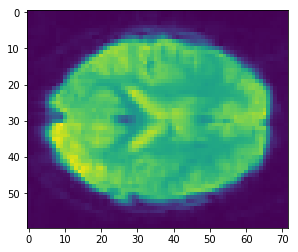

In [2]:
from matplotlib import pyplot as plt
my_slice = X[0,6,:,:,30,0]
%matplotlib inline
plt.imshow(my_slice, interpolation='nearest')
plt.show()

Let us now show an output from the trained model:

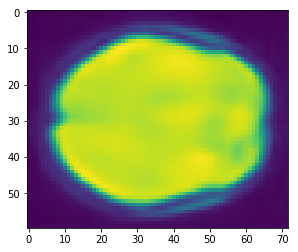

In [6]:
from matplotlib import pyplot as plt
my_slice = outs[55,11,:,:,24,0]
%matplotlib inline
plt.imshow(my_slice / np.max(my_slice), interpolation='nearest')
plt.show()

It is alive!